In [ ]:
!pip install gensim

In [ ]:
# =========================
# 1. Import Libraries
# =========================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim.models import Word2Vec
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:

# 2. Load Dataset
# =========================
df = pd.read_csv("/content/drive/MyDrive/dataset/dataset_mood_tweet.csv")
df.head()

,Unnamed: 0,full_text,mood
0,0,Semangat yaa walaupun berat laluin aja.. perca...,senang
1,1,@kdylovs Happy birthday kakak kakakku ️ Bahagi...,senang
2,2,@whiteulia semangat sekulah nyaaa,senang
3,3,@_cupacupzzz semangat kak kiki,senang
4,4,Kmu bukan kelilit hutang sayang. Kamu kelilit ...,senang


In [ ]:
# prompt: drop Unnamed: 0

df = df.drop(columns=['Unnamed: 0'])
df.columns


Index(['full_text', 'mood'], dtype='object')

**EDA**

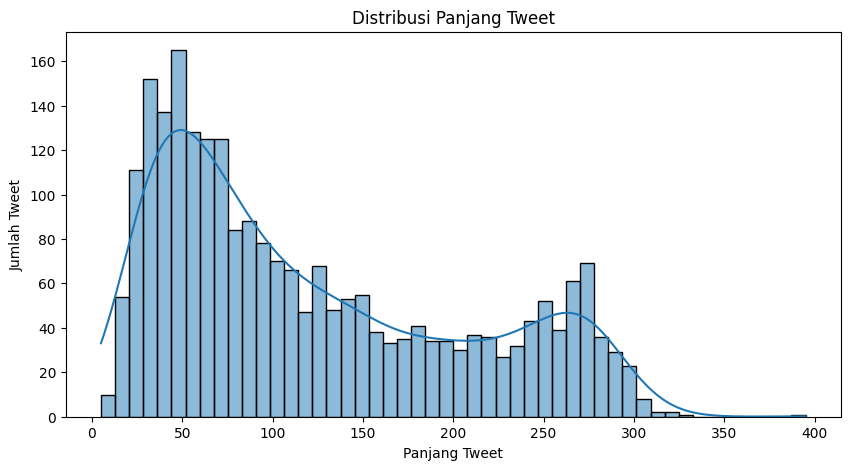

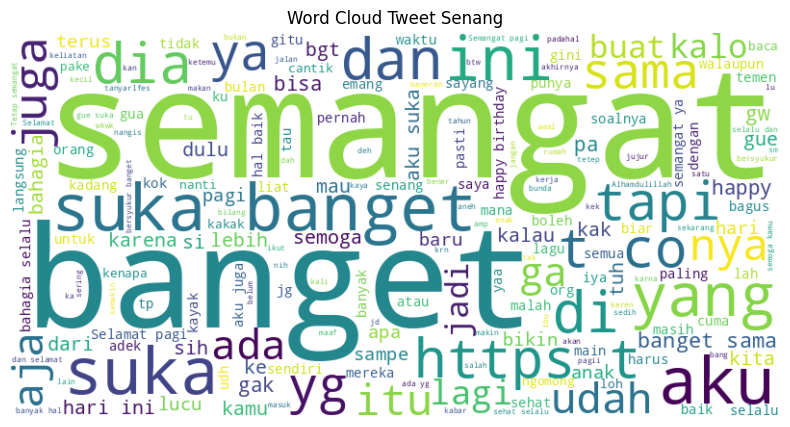

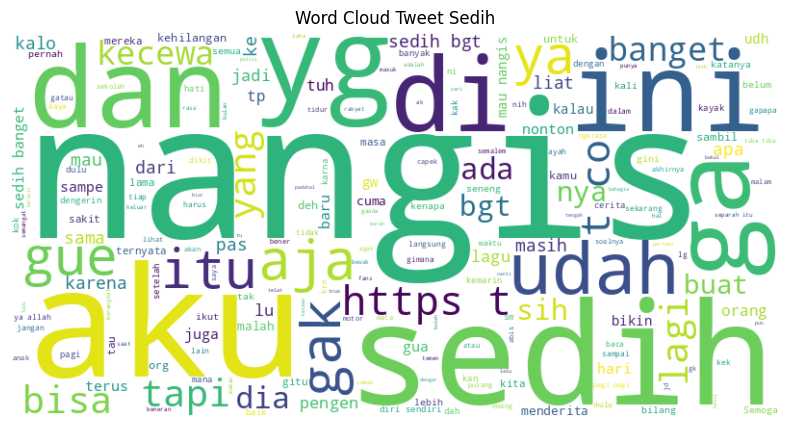

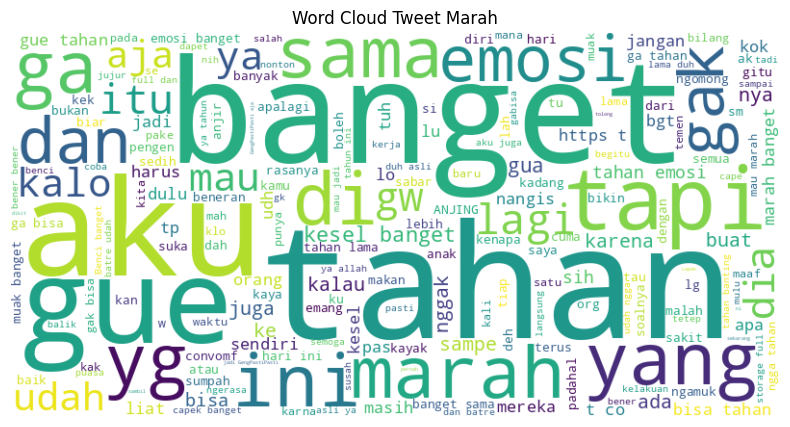

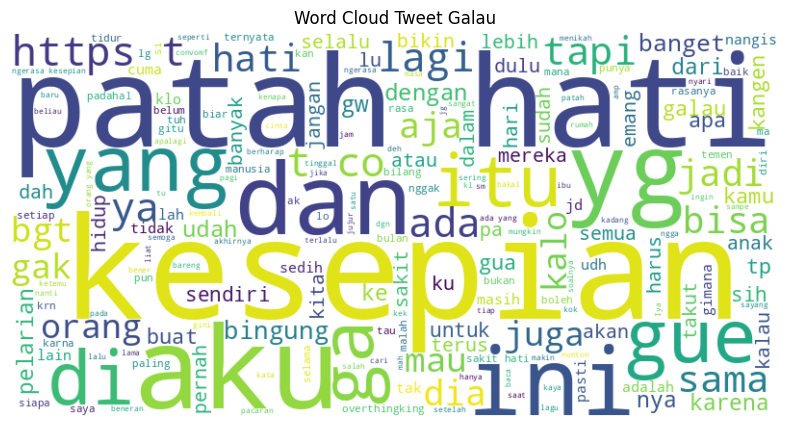

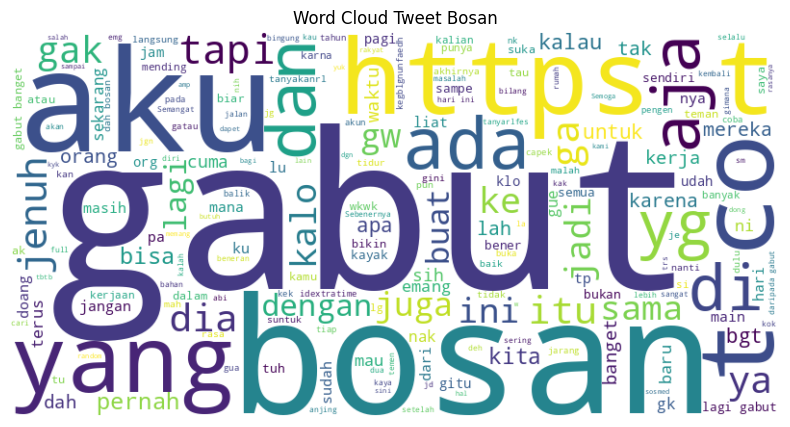

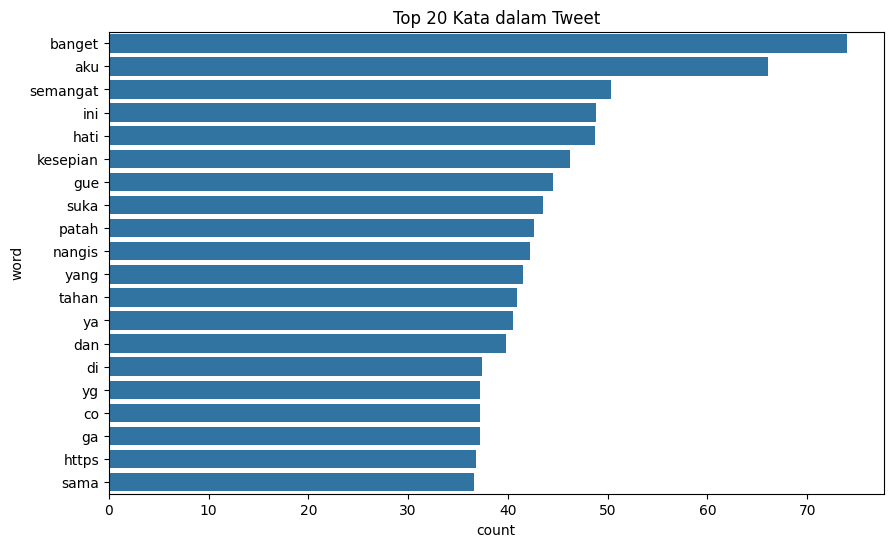

In [ ]:
# prompt: tambahkan visualisasinya

import pandas as pd
import matplotlib.pyplot as plt
# Analisis panjang tweet
df['tweet_length'] = df['full_text'].apply(len)
plt.figure(figsize=(10, 5))
sns.histplot(data=df, x='tweet_length', bins=50, kde=True)
plt.title("Distribusi Panjang Tweet")
plt.xlabel("Panjang Tweet")
plt.ylabel("Jumlah Tweet")
plt.show()

import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS

def create_wordcloud(text_list, title):
    text = " ".join(text_list)
    stopwords = set(STOPWORDS)
    wordcloud = WordCloud(width=800, height=400, background_color='white', stopwords=stopwords).generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(title)
    plt.show()

for mood_label in df['mood'].unique():
    tweets = df[df['mood'] == mood_label]['full_text'].tolist()
    if tweets:
        create_wordcloud(tweets, f"Word Cloud Tweet {mood_label.capitalize()}")


# Visualisasi frekuensi kata (Top N words)
def get_top_n_words(corpus, n=None):
    vec = TfidfVectorizer().fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

if 'full_text' in df.columns:
    common_words = get_top_n_words(df['full_text'].astype(str), 20) # Top 20 kata
    df_common_words = pd.DataFrame(common_words, columns = ['word' , 'count'])

    plt.figure(figsize=(10, 6))
    sns.barplot(x='count', y='word', data=df_common_words)
    plt.title('Top 20 Kata dalam Tweet')
    plt.show()

<ipython-input-16-c362f9a30648>:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(data=df, x='mood', order=order, palette='Set2')


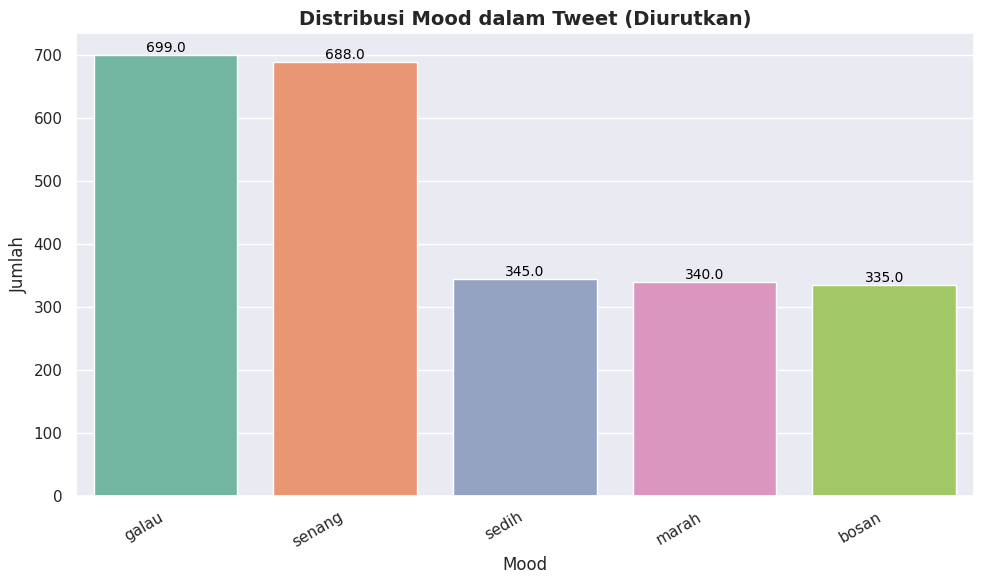

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set tema
sns.set_theme(style="darkgrid")

# Hitung jumlah masing-masing kategori 'Mood'
order = df['mood'].value_counts().index

# Buat plot dengan urutan berdasarkan jumlah
plt.figure(figsize=(10, 6))
ax = sns.countplot(data=df, x='mood', order=order, palette='Set2')

# Tambahkan label jumlah di atas batang
for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{height}', (p.get_x() + p.get_width() / 2., height),
                ha='center', va='bottom', fontsize=10, color='black')

# Judul dan label
plt.title("Distribusi Mood dalam Tweet (Diurutkan)", fontsize=14, weight='bold')
plt.xlabel("Mood", fontsize=12)
plt.ylabel("Jumlah", fontsize=12)
plt.xticks(rotation=30, ha='right')
plt.tight_layout()

plt.show()

In [ ]:
# Display the first few rows of the dataframe
print(df.head())

# Get data information
print(df.info())

# Describe numerical features
print(df.describe())

# Check for missing values
print(df.isnull().sum())

                                           full_text    mood  tweet_length
0  Semangat yaa walaupun berat laluin aja.. perca...  senang           173
1  @kdylovs Happy birthday kakak kakakku ️ Bahagi...  senang           100
2                  @whiteulia semangat sekulah nyaaa  senang            33
3                     @_cupacupzzz semangat kak kiki  senang            30
4  Kmu bukan kelilit hutang sayang. Kamu kelilit ...  senang            73
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2407 entries, 0 to 2406
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   full_text     2407 non-null   object
 1   mood          2407 non-null   object
 2   tweet_length  2407 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 56.5+ KB
None
       tweet_length
count   2407.000000
mean     120.637308
std       83.644709
min        5.000000
25%       51.000000
50%       93.000000
75%      183.500000
max      395.00000

**PREPROCESSING**

In [ ]:
!pip install Sastrawi

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.7/209.7 kB 4.8 MB/s eta 0:00:00


In [ ]:
def clean_text(text):
    text = re.sub(r'@[A-Za-z0-9]+', '', text) # menghapus mention
    text = re.sub(r'#[A-Za-z0-9]+', '', text) # menghapus hashtag
    text = re.sub(r'RT[\s]', '', text) # menghapus RT
    text = re.sub(r"http\S+", '', text) # menghapus link
    text = re.sub(r'\d+', '', text) # menghapus angka
    text = re.sub(r'[^\w\s]', '', text) # menghapus karakter selain huruf dan angka
    text = text.replace('\n', ' ') # mengganti baris baru dengan spasi
    text = text.translate(str.maketrans('', '', string.punctuation)) # menghapus semua tanda baca
    text = text.strip(' ') # menghapus karakter spasi dari kiri dan kanan teks
    return text
def casefolding(text):
    text = text.lower() # mengubah teks menjadi huruf kecil
    return text
def tokenizing(text):
    text = word_tokenize(text) # melakukan tokenisasi teks
    return text
def filter(text):
    stop_words = set(stopwords.words('indonesian')) # menghapus stopwords
    text = [word for word in text if word not in stop_words]
    return text
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
def stemming(text): # Mengurangi kata ke bentuk dasarnya yang menghilangkan imbuhan awalan dan akhiran atau ke akar kata
    factory = StemmerFactory()
    stemmer = factory.create_stemmer()
    words = text.split()
    stemmed_words = [stemmer.stem(word) for word in words]
    stemmed_text = ' '.join(stemmed_words)
    return stemmed_text
def sentence(list_words): # Mengubah daftar kata menjadi kalimat
    sentence = ' '.join(word for word in list_words)
    return sentence

In [ ]:
# Load kamus alay
kamus_alay_df = pd.read_csv('/content/drive/MyDrive/dataset/Kamus-Alay.csv', names=['alay', 'baku'])

# Ubah jadi dictionary
kamus_alay_dict = dict(zip(kamus_alay_df['alay'], kamus_alay_df['baku']))

# Fungsi untuk memperbaiki slang word
def fix_slangwords(text):
    words = text.split()
    fixed_words = []

    for word in words:
        fixed_words.append(kamus_alay_dict.get(word.lower(), word))

    return ' '.join(fixed_words)

In [ ]:
import nltk
nltk.download('punkt')
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [ ]:
# Membersihkan teks dan menyimpannya di kolom 'text_clean'
df['text_clean'] = df['full_text'].apply(clean_text)

# Mengubah huruf dalam teks menjadi huruf kecil dan menyimpannya di 'text_casefoldingText'
df['text_casefoldingText'] = df['text_clean'].apply(casefolding)

# Mengganti kata-kata slang dengan kata-kata standar dan menyimpannya di 'text_slangwords'
df['text_slangwords'] = df['text_casefoldingText'].apply(fix_slangwords)

# Memecah teks menjadi token (kata-kata) dan menyimpannya di 'text_tokenizingText'
df['text_tokenizingText'] = df['text_slangwords'].apply(tokenizing)

# Menghapus kata-kata stop (kata-kata umum) dan menyimpannya di 'text_stopword'
df['text_stopword'] = df['text_tokenizingText'].apply(filter)

# Menggabungkan token-token menjadi kalimat dan menyimpannya di 'text_sentence'
df['text_sentence'] = df['text_stopword'].apply(sentence)

# Menambahkan tahap stemming dan menyimpannya di 'text_akhir'
df['text_akhir'] = df['text_sentence'].apply(stemming)


In [ ]:
# prompt: tampilkan text akhir

print(df['text_akhir'])

0       semangat ya berat laluin percaya dh solusi gak...
1       bahagia birthday kakak kakak bahagia ganteng n...
2                                    semangat kulah nyaaa
3                            cupacupzzz semangat kak kiki
4       kmu lilit hutang sayang lilit lemak semangat i...
                              ...                        
2402         iyaa jenuh kertas alih koleksi skzoo minivee
2403                                    cepat sembuh brok
2404    ush serious lahhhhh hahaa jenuh kenan kena pus...
2405             nya bosan lihat lihat masuk keranjang co
2406                        jodoh datengnya suka gak duga
Name: text_akhir, Length: 2407, dtype: object


In [ ]:
df.head()

,full_text,mood,tweet_length,text_clean,text_casefoldingText,text_slangwords,text_tokenizingText,text_stopword,text_sentence,text_akhir
0,Semangat yaa walaupun berat laluin aja.. perca...,senang,173,Semangat yaa walaupun berat laluin aja percaya...,semangat yaa walaupun berat laluin aja percaya...,semangat ya walaupun berat laluin saja percaya...,"[semangat, ya, walaupun, berat, laluin, saja, ...","[semangat, ya, berat, laluin, percaya, dh, sol...",semangat ya berat laluin percaya dh solusinya ...,semangat ya berat laluin percaya dh solusi gak...
1,@kdylovs Happy birthday kakak kakakku ️ Bahagi...,senang,100,Happy birthday kakak kakakku Bahagia selalu g...,happy birthday kakak kakakku bahagia selalu g...,bahagia birthday kakak kakakku bahagia selalu ...,"[bahagia, birthday, kakak, kakakku, bahagia, s...","[bahagia, birthday, kakak, kakakku, bahagia, g...",bahagia birthday kakak kakakku bahagia ganteng...,bahagia birthday kakak kakak bahagia ganteng n...
2,@whiteulia semangat sekulah nyaaa,senang,33,semangat sekulah nyaaa,semangat sekulah nyaaa,semangat sekulah nyaaa,"[semangat, sekulah, nyaaa]","[semangat, sekulah, nyaaa]",semangat sekulah nyaaa,semangat kulah nyaaa
3,@_cupacupzzz semangat kak kiki,senang,30,cupacupzzz semangat kak kiki,cupacupzzz semangat kak kiki,cupacupzzz semangat kak kiki,"[cupacupzzz, semangat, kak, kiki]","[cupacupzzz, semangat, kak, kiki]",cupacupzzz semangat kak kiki,cupacupzzz semangat kak kiki
4,Kmu bukan kelilit hutang sayang. Kamu kelilit ...,senang,73,Kmu bukan kelilit hutang sayang Kamu kelilit l...,kmu bukan kelilit hutang sayang kamu kelilit l...,kmu bukan kelilit hutang sayang kamu kelilit l...,"[kmu, bukan, kelilit, hutang, sayang, kamu, ke...","[kmu, kelilit, hutang, sayang, kelilit, lemak,...",kmu kelilit hutang sayang kelilit lemak semang...,kmu lilit hutang sayang lilit lemak semangat i...


In [ ]:
# prompt: lakukan encoded mood dan kasih jelas label dan encodenya

from sklearn.preprocessing import LabelEncoder

# Inisialisasi LabelEncoder
label_encoder = LabelEncoder()

# Lakukan encoding pada kolom 'mood'
df['mood_encoded'] = label_encoder.fit_transform(df['mood'])

# Tampilkan mapping label ke angka
# label_encoder.classes_ berisi nama-nama kelas (label) asli
# label_encoder.transform akan mengembalikan nilai numerik untuk setiap label
print("Mapping Mood Labels to Encoded Values:")
for label, encoded_value in zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)):
    print(f"'{label}': {encoded_value}")

# Tampilkan beberapa baris pertama dengan kolom 'mood_encoded'
print("\nDataFrame with 'mood_encoded' column:")
print(df[['mood', 'mood_encoded']].head())

Mapping Mood Labels to Encoded Values:
'bosan': 0
'galau': 1
'marah': 2
'sedih': 3
'senang': 4

DataFrame with 'mood_encoded' column:
     mood  mood_encoded
0  senang             4
1  senang             4
2  senang             4
3  senang             4
4  senang             4


In [ ]:
import joblib

# Simpan label encoder ke file
joblib.dump(label_encoder, "label_encoder.joblib")
print("✅ LabelEncoder berhasil disimpan ke 'label_encoder.joblib'")


In [ ]:
# prompt: df= 'text_akhir','mood', 'mood_encoded'

df = df[['text_akhir','mood', 'mood_encoded']]
print(df.head())

                                          text_akhir    mood  mood_encoded
0  semangat ya berat laluin percaya dh solusi gak...  senang             4
1  bahagia birthday kakak kakak bahagia ganteng n...  senang             4
2                               semangat kulah nyaaa  senang             4
3                       cupacupzzz semangat kak kiki  senang             4
4  kmu lilit hutang sayang lilit lemak semangat i...  senang             4


In [ ]:
# Menyimpan dataframe ke file CSV tanpa index
df.to_csv('dataset_preprocessing.csv', index=False)

**PEMODELAN RANDOM FOREST**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# 1. Load Dataset PREPROCESSING
# =========================
df = pd.read_csv("/content/drive/MyDrive/dataset/dataset_preprocessing.csv")
df.head()

,text_akhir,mood,mood_encoded
0,semangat ya berat laluin percaya dh solusi gak...,senang,4
1,bahagia birthday kakak kakak bahagia ganteng n...,senang,4
2,semangat kulah nyaaa,senang,4
3,cupacupzzz semangat kak kiki,senang,4
4,kmu lilit hutang sayang lilit lemak semangat i...,senang,4


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from imblearn.over_sampling import RandomOverSampler
import seaborn as sns
import matplotlib.pyplot as plt

# Drop rows with NaN values in 'text_akhir'
df.dropna(subset=['text_akhir'], inplace=True)

# Fitur dan label
X_text = df['text_akhir']
y = df['mood_encoded']

# TF-IDF vectorization
tfidf = TfidfVectorizer()
X_tfidf = tfidf.fit_transform(X_text)




=== Akurasi Tiap Split ===
Split 90:10 - Train: 0.9985, Val: 0.9515, Test: 0.9129
Split 80:20 - Train: 0.9986, Val: 0.9325, Test: 0.9356
Split 70:30 - Train: 0.9979, Val: 0.9377, Test: 0.9335
Split 60:40 - Train: 0.9981, Val: 0.9204, Test: 0.9387
Split 50:50 - Train: 0.9986, Val: 0.9253, Test: 0.9393

Akurasi Terbaik Keseluruhan: Train Accuracy = 0.9986 pada Split 80:20

=== Classification Report (Train) ===
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       442
           1       1.00      1.00      1.00       442
           2       1.00      1.00      1.00       442
           3       1.00      1.00      1.00       442
           4       1.00      1.00      1.00       442

    accuracy                           1.00      2210
   macro avg       1.00      1.00      1.00      2210
weighted avg       1.00      1.00      1.00      2210

=== Classification Report (Validation) ===
              precision    recall  f1-score   support

 

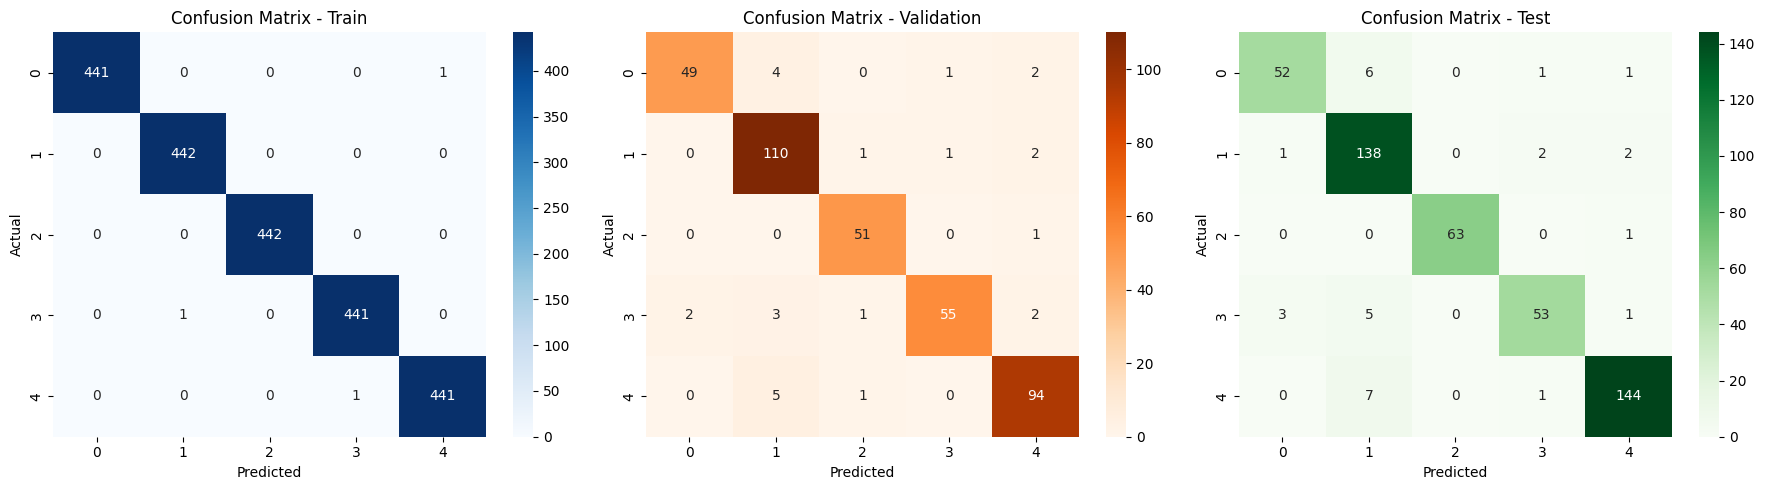

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Rasio split yang akan diuji
splits = [0.1, 0.2, 0.3, 0.4, 0.5]
results = {}
models = {}
all_accuracies = []

for test_size in splits:
    # Bagi data awal menjadi train+val dan test
    X_temp, X_test, y_temp, y_test = train_test_split(X_tfidf, y, test_size=test_size, random_state=42)

    # Bagi lagi X_temp menjadi train dan val (80% train, 20% val dari X_temp)
    X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.2, random_state=42)

    # Terapkan SMOTE hanya pada data training
    smote = SMOTE(random_state=42)
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

    # Latih model
    model = RandomForestClassifier(random_state=42)
    model.fit(X_train_resampled, y_train_resampled)

    # Prediksi
    y_pred_train = model.predict(X_train_resampled)
    y_pred_val = model.predict(X_val)
    y_pred_test = model.predict(X_test)

    # Akurasi
    acc_train = accuracy_score(y_train_resampled, y_pred_train)
    acc_val = accuracy_score(y_val, y_pred_val)
    acc_test = accuracy_score(y_test, y_pred_test)

    split_ratio = f"{int((1 - test_size) * 100)}:{int(test_size * 100)}"
    results[split_ratio] = {
        'train': acc_train,
        'val': acc_val,
        'test': acc_test
    }
    all_accuracies.extend([
        ('Train', split_ratio, acc_train),
        ('Validation', split_ratio, acc_val),
        ('Test', split_ratio, acc_test)
    ])
    models[split_ratio] = (model, X_train_resampled, X_val, X_test, y_train_resampled, y_val, y_test)

# Cetak semua akurasi
print("=== Akurasi Tiap Split ===")
for split, accs in results.items():
    print(f"Split {split} - Train: {accs['train']:.4f}, Val: {accs['val']:.4f}, Test: {accs['test']:.4f}")

# Cari akurasi terbaik dari semua
best_overall = max(all_accuracies, key=lambda x: x[2])
print(f"\nAkurasi Terbaik Keseluruhan: {best_overall[0]} Accuracy = {best_overall[2]:.4f} pada Split {best_overall[1]}")

# Gunakan model terbaik
best_model_data = models[best_overall[1]]
best_model, X_train_resampled, X_val, X_test, y_train_resampled, y_val, y_test = best_model_data

# Evaluasi akhir
y_pred_train = best_model.predict(X_train_resampled)
y_pred_val = best_model.predict(X_val)
y_pred_test = best_model.predict(X_test)

# Classification Report
print("\n=== Classification Report (Train) ===")
print(classification_report(y_train_resampled, y_pred_train))
print("=== Classification Report (Validation) ===")
print(classification_report(y_val, y_pred_val))
print("=== Classification Report (Test) ===")
print(classification_report(y_test, y_pred_test))

# Confusion Matrices
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

sns.heatmap(confusion_matrix(y_train_resampled, y_pred_train), annot=True, fmt="d", cmap="Blues", ax=axes[0])
axes[0].set_title("Confusion Matrix - Train")
axes[0].set_xlabel("Predicted")
axes[0].set_ylabel("Actual")

sns.heatmap(confusion_matrix(y_val, y_pred_val), annot=True, fmt="d", cmap="Oranges", ax=axes[1])
axes[1].set_title("Confusion Matrix - Validation")
axes[1].set_xlabel("Predicted")
axes[1].set_ylabel("Actual")

sns.heatmap(confusion_matrix(y_test, y_pred_test), annot=True, fmt="d", cmap="Greens", ax=axes[2])
axes[2].set_title("Confusion Matrix - Test")
axes[2].set_xlabel("Predicted")
axes[2].set_ylabel("Actual")

plt.tight_layout()
plt.show()


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
import joblib

# Simpan ke file
joblib.dump(model, "random_forest_best_model.joblib")
joblib.dump(tfidf, "tfidf_vectorizer.joblib")


['tfidf_vectorizer.joblib']

**PEMODELAN MLP (MULTI LINEAR PERCETPRON)**

In [ ]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from imblearn.over_sampling import SMOTE

In [ ]:
dataset = pd.read_csv("/content/drive/MyDrive/dataset/dataset_preprocessing.csv")
dataset.head()

,text_akhir,mood,mood_encoded
0,semangat ya berat laluin percaya dh solusi gak...,senang,4
1,bahagia birthday kakak kakak bahagia ganteng n...,senang,4
2,semangat kulah nyaaa,senang,4
3,cupacupzzz semangat kak kiki,senang,4
4,kmu lilit hutang sayang lilit lemak semangat i...,senang,4


In [ ]:
dataset.isna().sum()
dataset.dropna(inplace=True)

In [ ]:
vectorizer = CountVectorizer(max_features=5000)
X = vectorizer.fit_transform(dataset['text_akhir']).toarray()
y = dataset['mood_encoded']

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

=== Akurasi Tiap Split ===
Split 90:10 - Train: 0.9849, Val: 0.9169, Test: 0.8880
Split 80:20 - Train: 0.9896, Val: 0.9065, Test: 0.9023
Split 70:30 - Train: 0.9907, Val: 0.8991, Test: 0.9100
Split 60:40 - Train: 0.9838, Val: 0.9239, Test: 0.9210
Split 50:50 - Train: 0.9823, Val: 0.9170, Test: 0.9085

Akurasi Terbaik Keseluruhan: Train Accuracy = 0.9907 pada Split 70:30
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step

=== Classification Report (Train - Resampled) ===
              precision    recall  f1-score   support

           0       0.97      0.99      0.98       387
           1       0.99      1.00      1.00       387
           2       1.00      1.00      1.00       387
           3       0.99      0.97      0.98       387
           4       1.00      0.99      0.99       387

    accuracy   

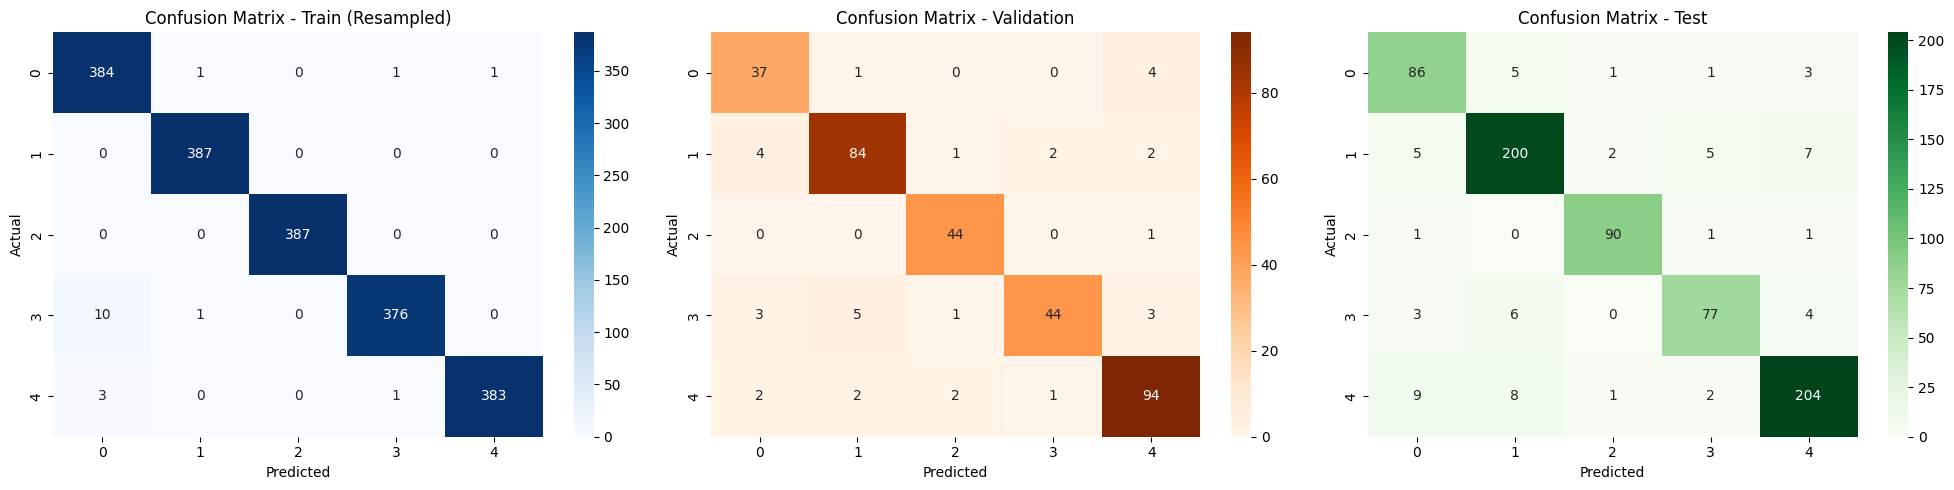

In [ ]:

# Rasio split yang akan diuji
splits = [0.1, 0.2, 0.3, 0.4, 0.5]
results = {}
models = {}
all_accuracies = []

# Konversi y ke array
y_array = np.array(y)

for test_size in splits:
    # Split sementara: train+val dan test
    X_temp, X_test, y_temp, y_test = train_test_split(X, y_array, test_size=test_size, random_state=42)

    # Split lagi menjadi train dan validation
    X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.2, random_state=42)

    # SMOTE pada train saja
    smote = SMOTE(random_state=42)
    X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

    # Model
    model = Sequential()
    model.add(Dense(128, activation='relu', input_shape=(X_train_res.shape[1],)))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(len(np.unique(y_array)), activation='softmax'))

    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    model.fit(X_train_res, y_train_res, epochs=10, batch_size=32, verbose=0)

    # Prediksi
    y_pred_train = np.argmax(model.predict(X_train_res), axis=1)
    y_pred_val = np.argmax(model.predict(X_val), axis=1)
    y_pred_test = np.argmax(model.predict(X_test), axis=1)

    acc_train = accuracy_score(y_train_res, y_pred_train)
    acc_val = accuracy_score(y_val, y_pred_val)
    acc_test = accuracy_score(y_test, y_pred_test)

    split_ratio = f"{int((1 - test_size) * 100)}:{int(test_size * 100)}"
    results[split_ratio] = {
        'train': acc_train,
        'val': acc_val,
        'test': acc_test
    }

    all_accuracies.extend([
        ('Train', split_ratio, acc_train),
        ('Validation', split_ratio, acc_val),
        ('Test', split_ratio, acc_test)
    ])

    models[split_ratio] = (model, X_train_res, X_val, X_test, y_train_res, y_val, y_test)

# Cetak akurasi
print("\n=== Akurasi Tiap Split ===")
for split, accs in results.items():
    print(f"Split {split} - Train: {accs['train']:.4f}, Val: {accs['val']:.4f}, Test: {accs['test']:.4f}")

# Cari split terbaik
best_overall = max(all_accuracies, key=lambda x: x[2])
print(f"\nAkurasi Terbaik Keseluruhan: {best_overall[0]} Accuracy = {best_overall[2]:.4f} pada Split {best_overall[1]}")

# Evaluasi ulang model terbaik
best_model_data = models[best_overall[1]]
best_model, X_train_res, X_val, X_test, y_train_res, y_val, y_test = best_model_data

# Prediksi ulang
y_pred_train = np.argmax(best_model.predict(X_train_res), axis=1)
y_pred_val = np.argmax(best_model.predict(X_val), axis=1)
y_pred_test = np.argmax(best_model.predict(X_test), axis=1)

# Classification Reports
print("\n=== Classification Report (Train - Resampled) ===")
print(classification_report(y_train_res, y_pred_train))
print("=== Classification Report (Validation) ===")
print(classification_report(y_val, y_pred_val))
print("=== Classification Report (Test) ===")
print(classification_report(y_test, y_pred_test))

# Confusion Matrices
fig, axes = plt.subplots(1, 3, figsize=(20, 5))

sns.heatmap(confusion_matrix(y_train_res, y_pred_train), annot=True, fmt='d', cmap='Blues', ax=axes[0])
axes[0].set_title("Confusion Matrix - Train (Resampled)")
axes[0].set_xlabel("Predicted")
axes[0].set_ylabel("Actual")

sns.heatmap(confusion_matrix(y_val, y_pred_val), annot=True, fmt='d', cmap='Oranges', ax=axes[1])
axes[1].set_title("Confusion Matrix - Validation")
axes[1].set_xlabel("Predicted")
axes[1].set_ylabel("Actual")

sns.heatmap(confusion_matrix(y_test, y_pred_test), annot=True, fmt='d', cmap='Greens', ax=axes[2])
axes[2].set_title("Confusion Matrix - Test")
axes[2].set_xlabel("Predicted")
axes[2].set_ylabel("Actual")

plt.tight_layout()
plt.show()


In [ ]:
best_model.save('mlp_model_v1.h5')
print("Model terbaik sudah disimpan sebagai 'mlp_model_v1.h5'")


Model terbaik sudah disimpan sebagai 'mlp_model_v1.h5'


In [ ]:
import joblib

In [ ]:
with open('bows_vectorizer.joblib', 'wb') as f:
    joblib.dump(vectorizer, f)

print("Vectorizer sudah disimpan di 'bows_vectorizer.joblib'")

Vectorizer sudah disimpan di 'bows_vectorizer.joblib'


**PEMODELAN ROBERTA**

In [ ]:
import pandas as pd
data = pd.read_csv("/content/drive/MyDrive/dataset/dataset_preprocessing.csv")
data.head()

,text_akhir,mood,mood_encoded
0,semangat ya berat laluin percaya dh solusi gak...,senang,4
1,bahagia birthday kakak kakak bahagia ganteng n...,senang,4
2,semangat kulah nyaaa,senang,4
3,cupacupzzz semangat kak kiki,senang,4
4,kmu lilit hutang sayang lilit lemak semangat i...,senang,4


In [ ]:
# prompt: cek nan

print(data.isna().sum())

text_akhir      3
mood            0
mood_encoded    0
dtype: int64


In [ ]:
# prompt: drop nan

data.dropna(inplace=True)

In [ ]:
# Prepare data
texts = data['text_akhir'].tolist()
labels = data['mood_encoded'].tolist()

In [ ]:

import numpy as np
import tensorflow as tf
from transformers import RobertaTokenizer, TFRobertaForSequenceClassification, create_optimizer
from gensim.models import Word2Vec
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler
from sklearn.preprocessing import LabelEncoder

# Pastikan semua teks adalah string
sentences = [str(text).split() for text in texts]
word2vec_model = Word2Vec(sentences, vector_size=100, window=5, min_count=2, workers=4)

# Ekstraksi fitur Word2Vec
word2vec_features = []
for text in texts:
    words = [w for w in str(text).split() if w in word2vec_model.wv]
    if words:
        word_vecs = word2vec_model.wv[words]
        word2vec_features.append(word_vecs.mean(axis=0))
    else:
        word2vec_features.append(np.zeros(word2vec_model.vector_size))
word2vec_features = np.array(word2vec_features)

In [ ]:
# Split data
train_texts, test_texts, train_labels, test_labels = train_test_split(
    texts, labels, test_size=0.2, random_state=42
)

# Initialize tokenizer
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')

# Tokenize input texts
train_encodings = tokenizer(list(map(str, train_texts)), truncation=True, padding=True, max_length=128, return_tensors='tf')
test_encodings = tokenizer(list(map(str, test_texts)), truncation=True, padding=True, max_length=128, return_tensors='tf')

# Create TensorFlow datasets
train_dataset = tf.data.Dataset.from_tensor_slices((dict(train_encodings), train_labels)).batch(16)
test_dataset = tf.data.Dataset.from_tensor_slices((dict(test_encodings), test_labels)).batch(16)

# Load pre-trained model
model = TFRobertaForSequenceClassification.from_pretrained('roberta-base', num_labels=len(set(labels)))

# Define optimizer and loss
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
num_train_steps = len(train_dataset) * 3  # for 3 epochs
num_warmup_steps = int(0.1 * num_train_steps)

optimizer, schedule = create_optimizer(
    init_lr=5e-5,
    num_train_steps=num_train_steps,
    num_warmup_steps=num_warmup_steps
)

model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

# Train model
history = model.fit(train_dataset, epochs=3, validation_data=test_dataset)

# Evaluate model
loss_value, accuracy = model.evaluate(test_dataset)
print(f"Test Loss: {loss_value:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaForSequenceClassification: ['roberta.embeddings.position_ids']
- This IS expected if you are initializing TFRobertaForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaForSequenceClassification 

Epoch 1/3
121/121 [==============================] - 2375s 19s/step - loss: 1.0657 - accuracy: 0.5575 - val_loss: 0.4840 - val_accuracy: 0.8358
Epoch 2/3
121/121 [==============================] - 2482s 21s/step - loss: 0.3488 - accuracy: 0.8840 - val_loss: 0.3890 - val_accuracy: 0.8815
Epoch 3/3
31/31 [==============================] - 136s 4s/step - loss: 0.3081 - accuracy: 0.9064
Test Loss: 0.3081
Test Accuracy: 0.9064


31/31 [==============================] - 144s 4s/step
Test Accuracy Score: 0.9064


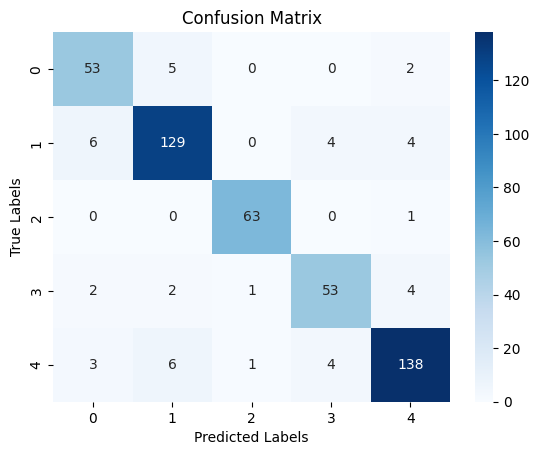

In [ ]:

# Prediksi dan Confusion Matrix
y_true = np.concatenate([y for x, y in test_dataset], axis=0)
y_pred = np.argmax(model.predict(test_dataset).logits, axis=-1)

print(f"Test Accuracy Score: {accuracy_score(y_true, y_pred):.4f}")

# Plot Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, cmap="Blues", fmt="d")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
# Simpan model Word2Vec
word2vec_model.save("/content/drive/MyDrive/dataset/word2vec_model.model")

In [ ]:
# Simpan model ke folder
model.save_pretrained("/content/drive/MyDrive/dataset/roberta_mood_model")
tokenizer.save_pretrained("/content/drive/MyDrive/dataset/roberta_mood_model")


('/content/drive/MyDrive/dataset/roberta_mood_model/tokenizer_config.json',
 '/content/drive/MyDrive/dataset/roberta_mood_model/special_tokens_map.json',
 '/content/drive/MyDrive/dataset/roberta_mood_model/vocab.json',
 '/content/drive/MyDrive/dataset/roberta_mood_model/merges.txt',
 '/content/drive/MyDrive/dataset/roberta_mood_model/added_tokens.json')

In [ ]:
import ipywidgets as widgets
from IPython.display import display, clear_output
import tensorflow as tf
from transformers import TFRobertaForSequenceClassification, RobertaTokenizer

# Load model dan tokenizer (ganti path sesuai model kamu)
model_path = '/content/drive/MyDrive/dataset/roberta_mood_model'  # folder model yang sudah kamu simpan

tokenizer = RobertaTokenizer.from_pretrained(model_path)
model = TFRobertaForSequenceClassification.from_pretrained(model_path)

# Label map sesuai kelasmu
labels = {0: "bosan", 1: "galau", 2: "marah", 3: "sedih", 4: "senang"}

# Buat widget input teks
text_input = widgets.Textarea(
    value='',
    placeholder='Masukkan tweet di sini...',
    description='Tweet:',
    layout=widgets.Layout(width='100%', height='100px')
)

# Tombol prediksi
button = widgets.Button(description="Prediksi Mood", button_style='success')

# Output area
output = widgets.Output()

def on_button_click(b):
    with output:
        clear_output()
        input_text = text_input.value.strip()
        if not input_text:
            print("Silakan masukkan teks terlebih dahulu.")
            return

        # Tokenisasi input
        inputs = tokenizer(input_text, return_tensors="tf", truncation=True, padding=True, max_length=128)
        # Prediksi
        outputs = model(inputs)
        logits = outputs.logits
        pred_class = tf.argmax(logits, axis=1).numpy()[0]

        # Tampilkan hasil prediksi
        print(f"Prediksi Mood: **{labels[pred_class]}**")

# Hubungkan tombol dengan fungsi
button.on_click(on_button_click)

# Tampilkan semua widget
display(text_input, button, output)


All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

All the layers of TFRobertaForSequenceClassification were initialized from the model checkpoint at /content/drive/MyDrive/dataset/roberta_mood_model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaForSequenceClassification for predictions without further training.


Textarea(value='', description='Tweet:', layout=Layout(height='100px', width='100%'), placeholder='Masukkan tw…

Button(button_style='success', description='Prediksi Mood', style=ButtonStyle())

Output()